In [1]:
# ## The imports
#the usuals
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
from datetime import timedelta
from math import sqrt
import importlib
from tqdm import tqdm
import joblib

import seaborn as sns
import matplotlib.dates as mdates


In [2]:

# plots
from matplotlib import style
style.use('default')

# Modeling
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import load_model

from sklearn.linear_model import LinearRegression

In [3]:
# Our custom utility functions
import utils
utils = importlib.reload(utils) #reload if utils.py is modified.
from utils import csvfileread, read_and_rename,create_dataset,convert_timestamp
from utils import atoi, natural_keys
from utils import load_electricity_demand_data
from utils import load_weather_data
from utils import train_LSTM_v1_on_features
from utils import get_dataset_with_condition

In [4]:
# Transformer-specific imports
from tensorflow.keras import layers, Model
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

## Merge and Compare All Models

In [6]:
# Load prediction CSVs
df_lstm = pd.read_csv('ML_Data/2023_lstm_prediction.csv', parse_dates=['timestamp'])
df_transformer = pd.read_csv('ML_Data/2023_transformer_pred.csv', parse_dates=['timestamp'])
df_lr = pd.read_csv('ML_Data/linear_regression_predictions_2023_updated.csv', parse_dates=['timestamp'])

In [7]:
# Rename columns for clarity
df_lstm.rename(columns={'predicted_demand': 'lstm_pred'}, inplace=True)

In [9]:
# Merge all on timestamp
merged_df = df_lstm.merge(df_transformer, on='timestamp', how='inner')
merged_df = merged_df.merge(df_lr, on='timestamp', how='inner')

In [10]:
# Drop rows with missing values
merged_df.dropna(inplace=True)

In [11]:
merged_df.head()

,timestamp,lstm_pred,ERCOT,transformer_pred,linear_regression_pred
0,2023-01-01 01:00:00,35083.950304,35609.173887,34703.830753,43231.574553
1,2023-01-01 02:00:00,35617.214363,35012.298856,34530.598541,41220.267288
2,2023-01-01 03:00:00,35721.843124,34369.582295,34052.180130,41345.789245
3,2023-01-01 04:00:00,35149.047775,34000.730337,33399.715560,44472.861881
4,2023-01-01 05:00:00,35371.010962,33865.078669,33548.010235,42824.906094


In [20]:
# Save merged data to a new CSV file
merged_df.to_csv('ML_Data/merged_all_predictions_2023.csv', index=False)

In [68]:
# Define evaluation function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    accuracy = 100 - mape
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "Final Accuracy (%)": accuracy
    }


In [69]:
# Evaluate all models
metrics_lstm = evaluate_model(merged_df['ERCOT'], merged_df['lstm_pred'])
metrics_trans = evaluate_model(merged_df['ERCOT'], merged_df['transformer_pred'])
metrics_lr = evaluate_model(merged_df['ERCOT'], merged_df['linear_regression_pred'])

In [70]:
# Display results
print("\n🔹 LSTM:", metrics_lstm)
print("🔹 Transformer:", metrics_trans)
print("🔹 Linear Regression:", metrics_lr)


🔹 LSTM: {'MAE': 3559.4111269504715, 'RMSE': 4701.071057963052, 'MAPE (%)': 6.687934251930663, 'Final Accuracy (%)': 93.31206574806933}
🔹 Transformer: {'MAE': 843.7989652423929, 'RMSE': 1198.5626651404443, 'MAPE (%)': 1.6742064766368552, 'Final Accuracy (%)': 98.32579352336315}
🔹 Linear Regression: {'MAE': 7792.4695195373115, 'RMSE': 10633.364369864194, 'MAPE (%)': 14.002559193987075, 'Final Accuracy (%)': 85.99744080601292}


In [71]:
# Display results neatly
print("\n Evaluation Results for 2023 ERCOT Forecasting:\n")
print("LSTM Model:")
print(f"   ➤ MAE               : {metrics_lstm['MAE']:.2f}")
print(f"   ➤ RMSE              : {metrics_lstm['RMSE']:.2f}")
print(f"   ➤ MAPE (%)          : {metrics_lstm['MAPE (%)']:.2f}%")
print(f"   ➤ Final Accuracy (%) : {metrics_lstm['Final Accuracy (%)']:.2f}%\n")

print("Transformer Model:")
print(f"   ➤ MAE               : {metrics_trans['MAE']:.2f}")
print(f"   ➤ RMSE              : {metrics_trans['RMSE']:.2f}")
print(f"   ➤ MAPE (%)          : {metrics_trans['MAPE (%)']:.2f}%")
print(f"   ➤ Final Accuracy (%) : {metrics_trans['Final Accuracy (%)']:.2f}%\n")

print("Linear Regression Model:")
print(f"   ➤ MAE               : {metrics_lr['MAE']:.2f}")
print(f"   ➤ RMSE              : {metrics_lr['RMSE']:.2f}")
print(f"   ➤ MAPE (%)          : {metrics_lr['MAPE (%)']:.2f}%")
print(f"   ➤ Final Accuracy (%) : {metrics_lr['Final Accuracy (%)']:.2f}%")



 Evaluation Results for 2023 ERCOT Forecasting:

LSTM Model:
   ➤ MAE               : 3559.41
   ➤ RMSE              : 4701.07
   ➤ MAPE (%)          : 6.69%
   ➤ Final Accuracy (%) : 93.31%

Transformer Model:
   ➤ MAE               : 843.80
   ➤ RMSE              : 1198.56
   ➤ MAPE (%)          : 1.67%
   ➤ Final Accuracy (%) : 98.33%

Linear Regression Model:
   ➤ MAE               : 7792.47
   ➤ RMSE              : 10633.36
   ➤ MAPE (%)          : 14.00%
   ➤ Final Accuracy (%) : 86.00%


In [72]:
# Save merged comparison file (optional)
#merged_df.to_csv('var/predictions/final_all_3_model_predictions.csv', index=False)

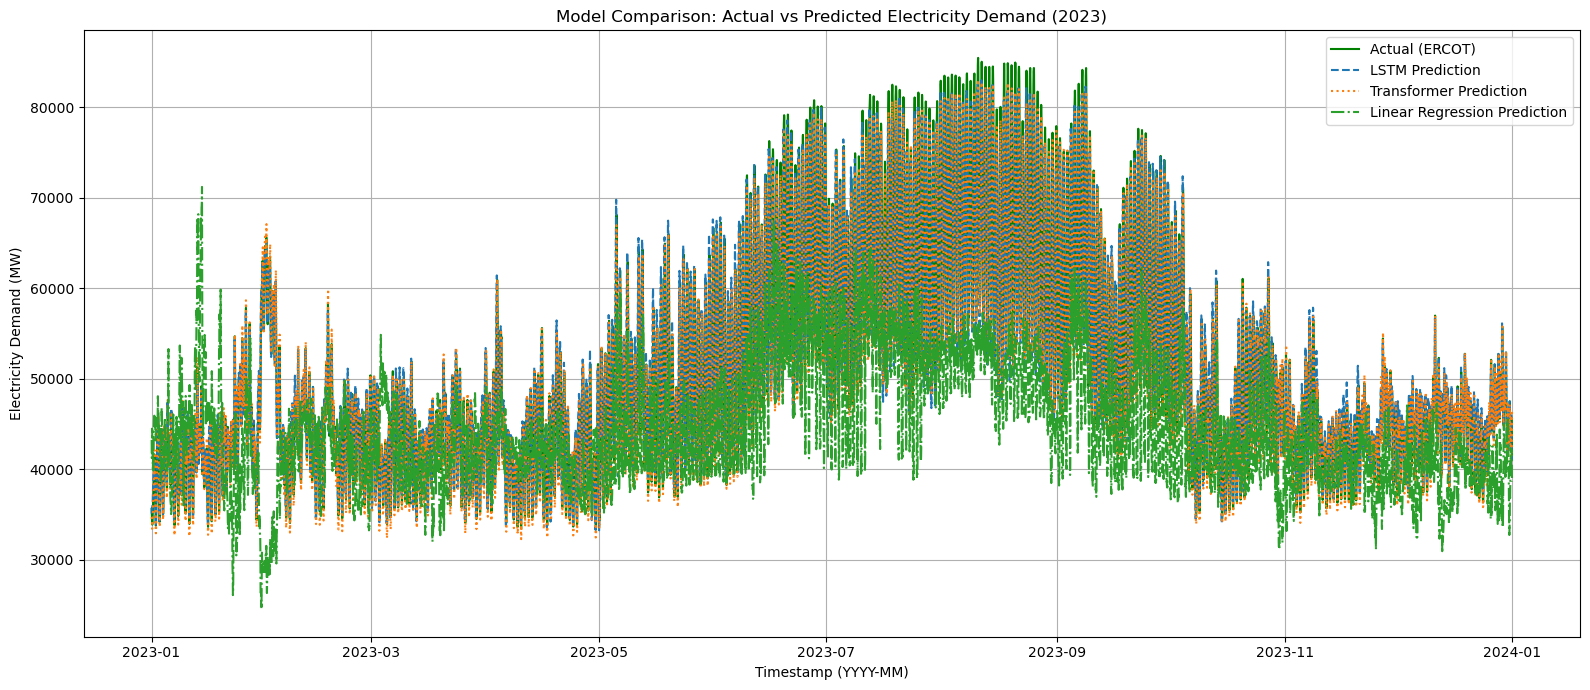

In [107]:
# Plot comparison
plt.figure(figsize=(16, 7))
plt.plot(merged_df['timestamp'], merged_df['ERCOT'], label='Actual (ERCOT)', color='green')
plt.plot(merged_df['timestamp'], merged_df['lstm_pred'], label='LSTM Prediction', linestyle='--')
plt.plot(merged_df['timestamp'], merged_df['transformer_pred'], label='Transformer Prediction', linestyle=':')
plt.plot(merged_df['timestamp'], merged_df['linear_regression_pred'], label='Linear Regression Prediction', linestyle='-.')
plt.title('Model Comparison: Actual vs Predicted Electricity Demand (2023)')
plt.xlabel('Timestamp (YYYY-MM)')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the image
plt.savefig('plots/model_comparison_2023.png', dpi=300)
plt.show()


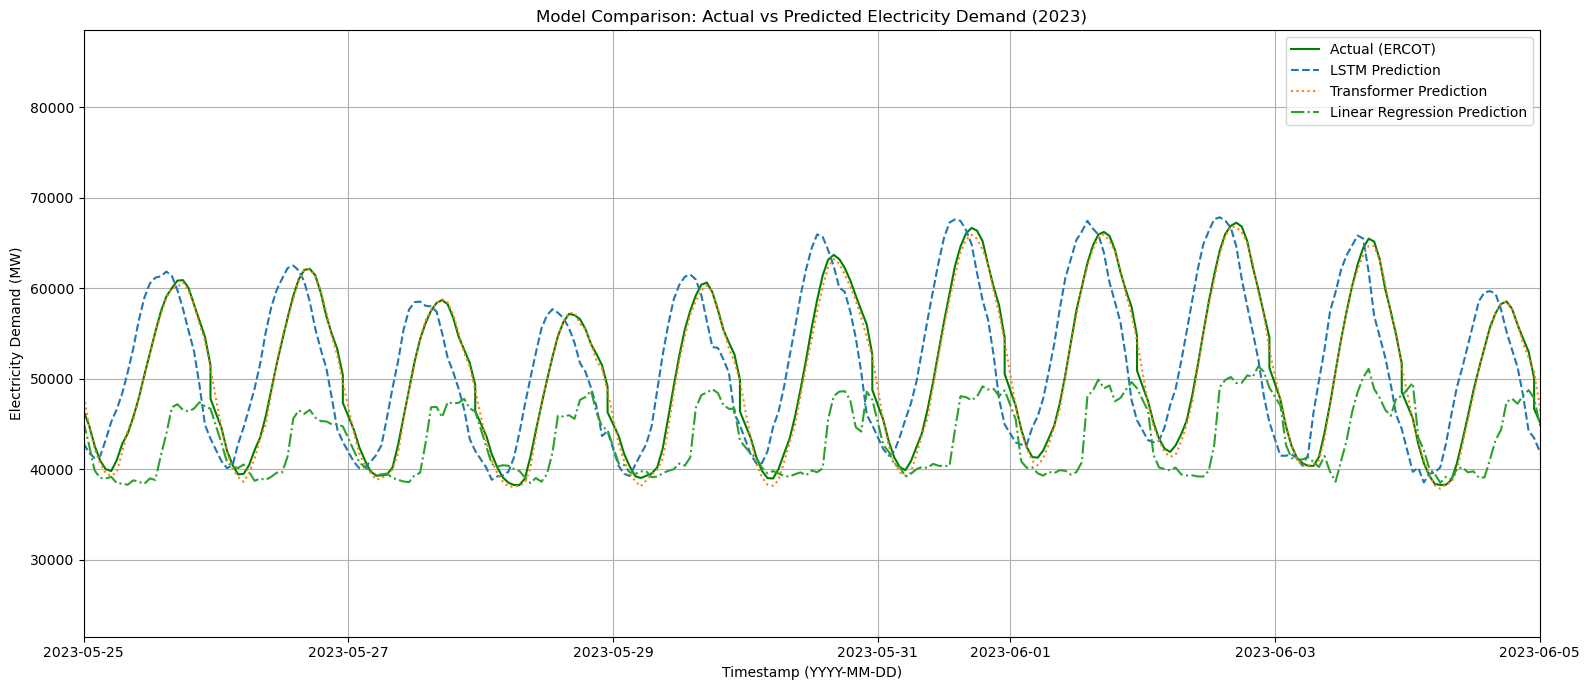

In [74]:
# Plot comparison
plt.figure(figsize=(16, 7))
plt.plot(merged_df['timestamp'], merged_df['ERCOT'], label='Actual (ERCOT)', color='green')
plt.plot(merged_df['timestamp'], merged_df['lstm_pred'], label='LSTM Prediction', linestyle='--')
plt.plot(merged_df['timestamp'], merged_df['transformer_pred'], label='Transformer Prediction', linestyle=':')
plt.plot(merged_df['timestamp'], merged_df['linear_regression_pred'], label='Linear Regression Prediction', linestyle='-.')
plt.title('Model Comparison: Actual vs Predicted Electricity Demand (2023)')
plt.xlabel('Timestamp (YYYY-MM-DD)')
plt.ylabel('Electricity Demand (MW)')
plt.xlim(datetime.datetime(2023,5,25), datetime.datetime(2023,6,5))
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the image
plt.savefig('plots/model_comparison_2023_sample_data.png', dpi=300)
plt.show()

## Evaluation for Year, Month, Day


In [76]:
# Helper to calculate metrics
def compute_metrics(y_true, y_pred):
    mae_val = mean_absolute_error(y_true, y_pred)
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    accuracy = 100 - mape
    return round(mape, 1), round(rmse_val, 1), round(accuracy, 1)

In [77]:
# Select Year (2023), Month (e.g. July), and Day (e.g. July 15)
year_df = merged_df.copy()
month_df = merged_df[merged_df['timestamp'].dt.month == 7]
day_df = merged_df[merged_df['timestamp'].dt.date == pd.to_datetime('2023-07-15').date()]

In [95]:
# Models and horizons
results = []

for label, df in zip(['Year (2023)', 'Month', 'Day'], [year_df, month_df, day_df]):
    # LSTM
    mape, rmse, acc = compute_metrics(df['ERCOT'], df['lstm_pred'])
    results.append(['LSTM', label, mape, rmse, acc])
    # Transformer
    mape, rmse, acc = compute_metrics(df['ERCOT'], df['transformer_pred'])
    results.append(['Transformer', label, mape, rmse, acc])
    # Linear Regression
    mape, rmse, acc = compute_metrics(df['ERCOT'], df['linear_regression_pred'])
    results.append(['Linear Regression', label, mape, rmse, acc])

In [97]:
# Convert to DataFrame for pretty output
table_df = pd.DataFrame(results, columns=['Model', 'Horizon', 'MAE (%)', 'RMSE (MW)', 'Acc. (%)'])

In [103]:
# # Show table without ace_tools
# print("\n Model Forecasting Metrics by Horizon\n")
# print(table_df.to_string(index=False))


In [105]:
table_df

,Model,Horizon,MAE (%),RMSE (MW),Acc. (%)
0,LSTM,Year (2023),6.7,4701.1,93.3
1,Transformer,Year (2023),1.7,1198.6,98.3
2,Linear Regression,Year (2023),14.0,10633.4,86.0
3,LSTM,Month,9.7,6928.3,90.3
4,Transformer,Month,1.7,1514.5,98.3
5,Linear Regression,Month,17.0,14110.6,83.0
6,LSTM,Day,10.5,7672.2,89.5
7,Transformer,Day,1.3,1109.3,98.7
8,Linear Regression,Day,16.8,13561.9,83.2


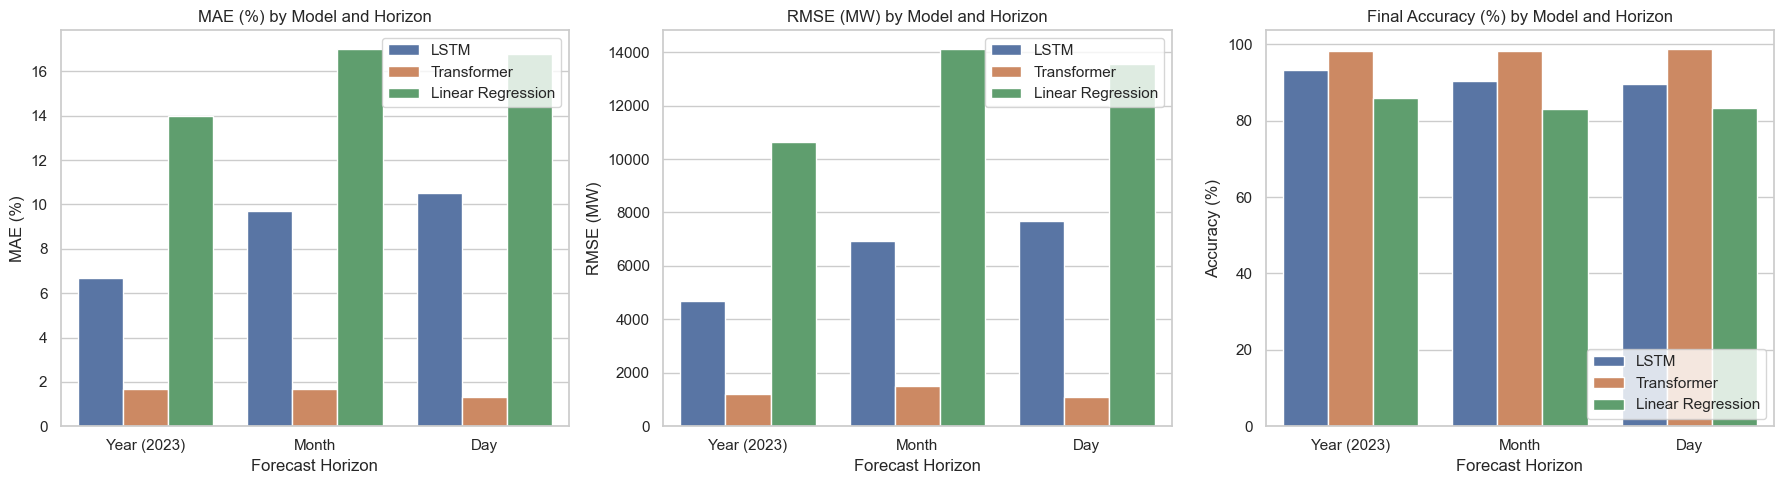

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure seaborn style is used
sns.set(style="whitegrid")

# Set plot size
plt.figure(figsize=(18, 5))

# Subplot 1: MAE (%)
plt.subplot(1, 3, 1)
sns.barplot(data=table_df, x='Horizon', y='MAE (%)', hue='Model')
plt.title('MAE (%) by Model and Horizon')
plt.ylabel('MAE (%)')
plt.xlabel('Forecast Horizon')
plt.legend(loc='upper right')

# Subplot 2: RMSE (MW)
plt.subplot(1, 3, 2)
sns.barplot(data=table_df, x='Horizon', y='RMSE (MW)', hue='Model')
plt.title('RMSE (MW) by Model and Horizon')
plt.ylabel('RMSE (MW)')
plt.xlabel('Forecast Horizon')
plt.legend(loc='upper right')

# Subplot 3: Final Accuracy (%)
plt.subplot(1, 3, 3)
sns.barplot(data=table_df, x='Horizon', y='Acc. (%)', hue='Model')
plt.title('Final Accuracy (%) by Model and Horizon')
plt.ylabel('Accuracy (%)')
plt.xlabel('Forecast Horizon')
plt.legend(loc='lower right')

# Save the image
plt.savefig('plots/Final Accuracy by Model and Horizon.png', dpi=300)

# Adjust layout and show
plt.tight_layout()
plt.show()


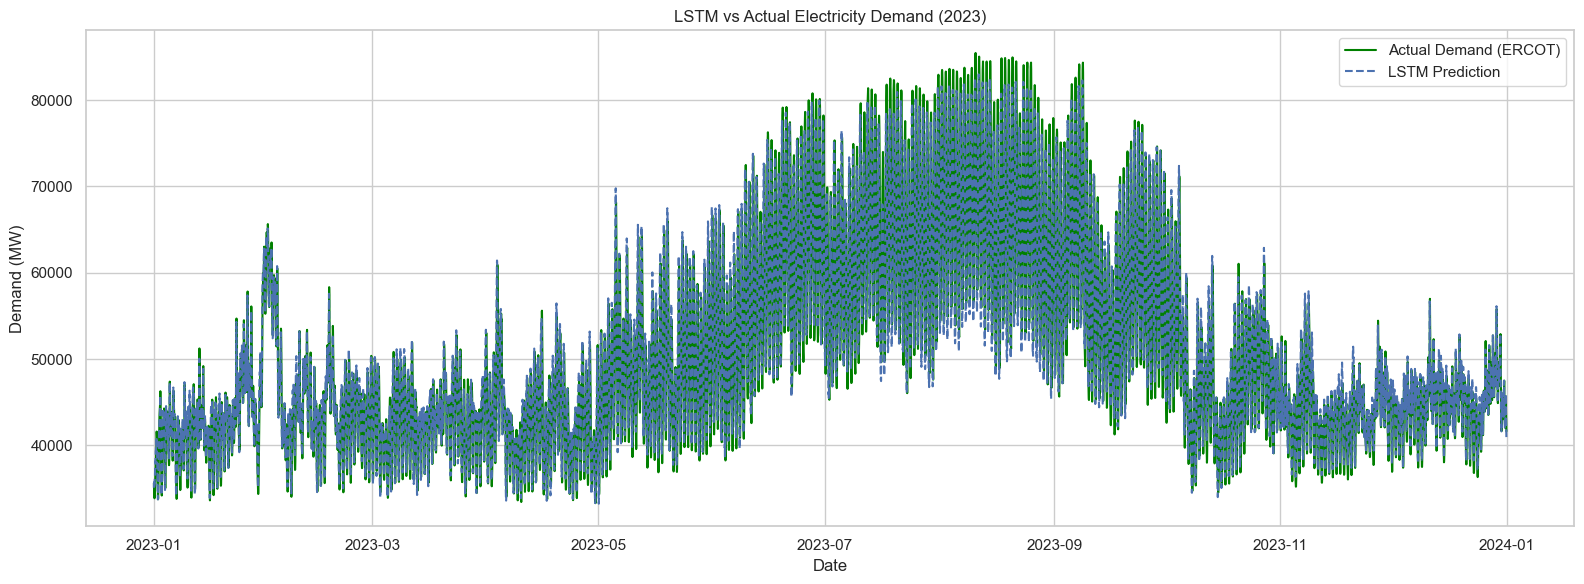

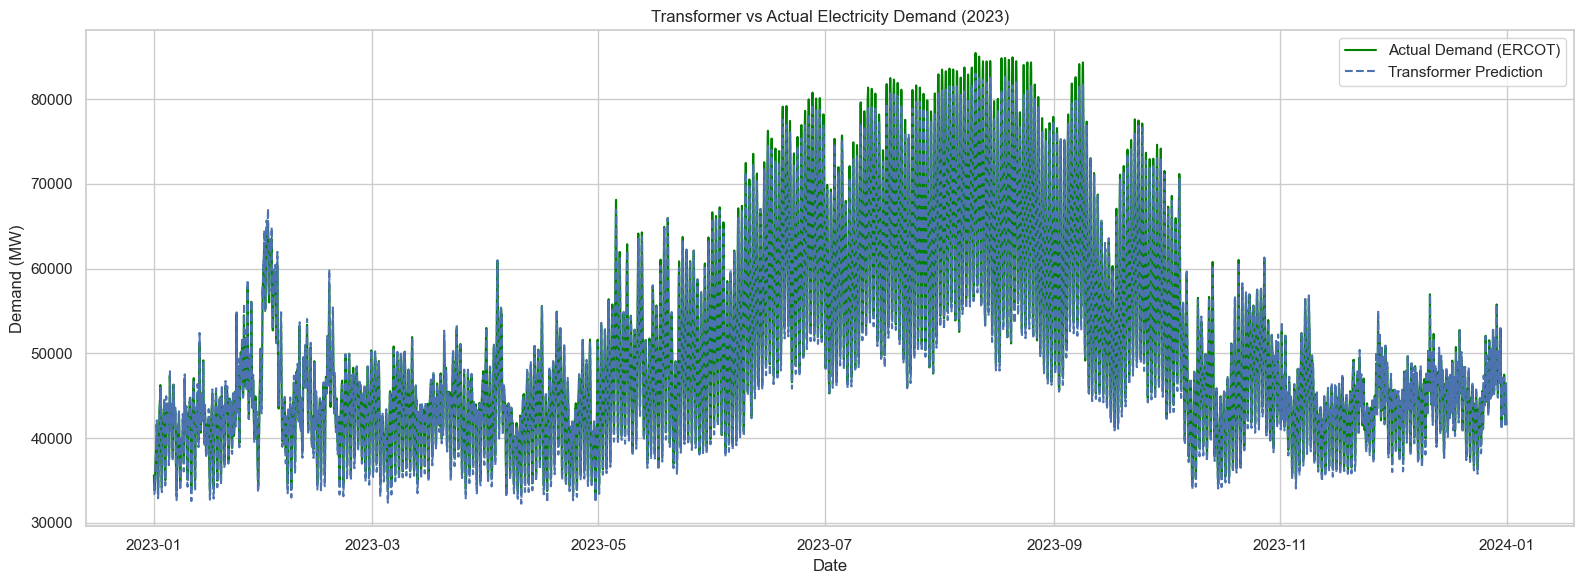

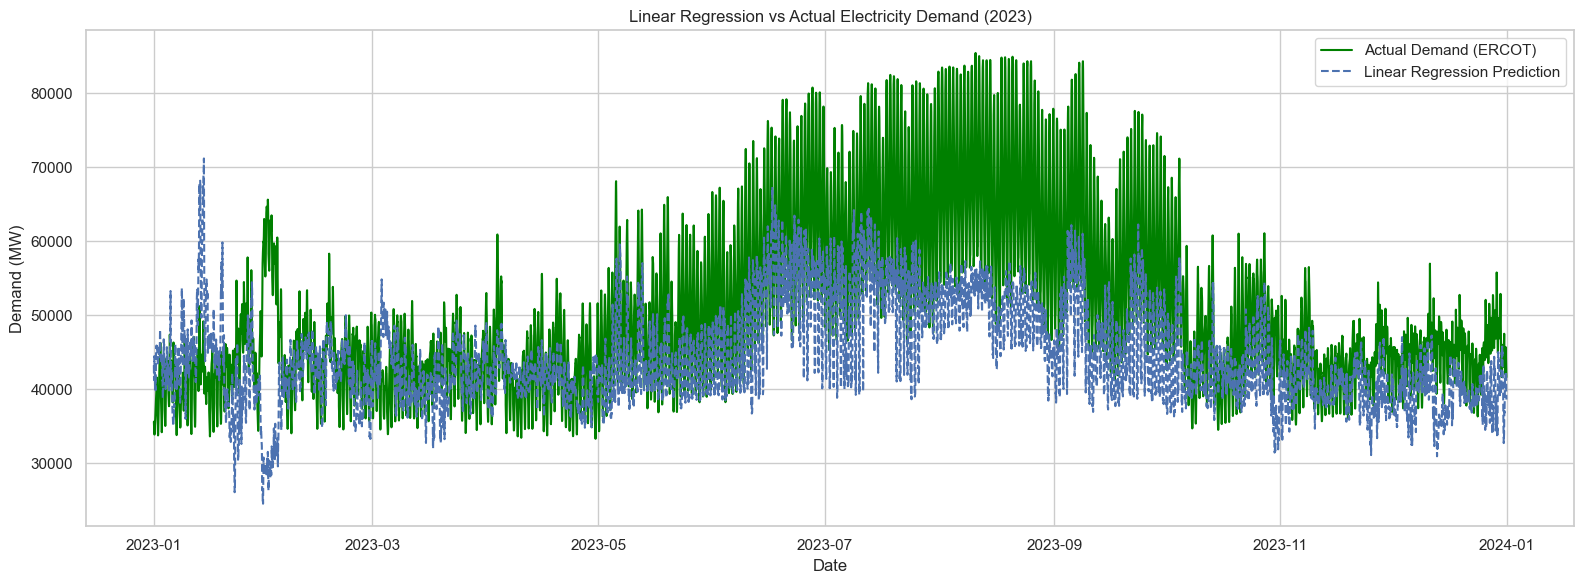

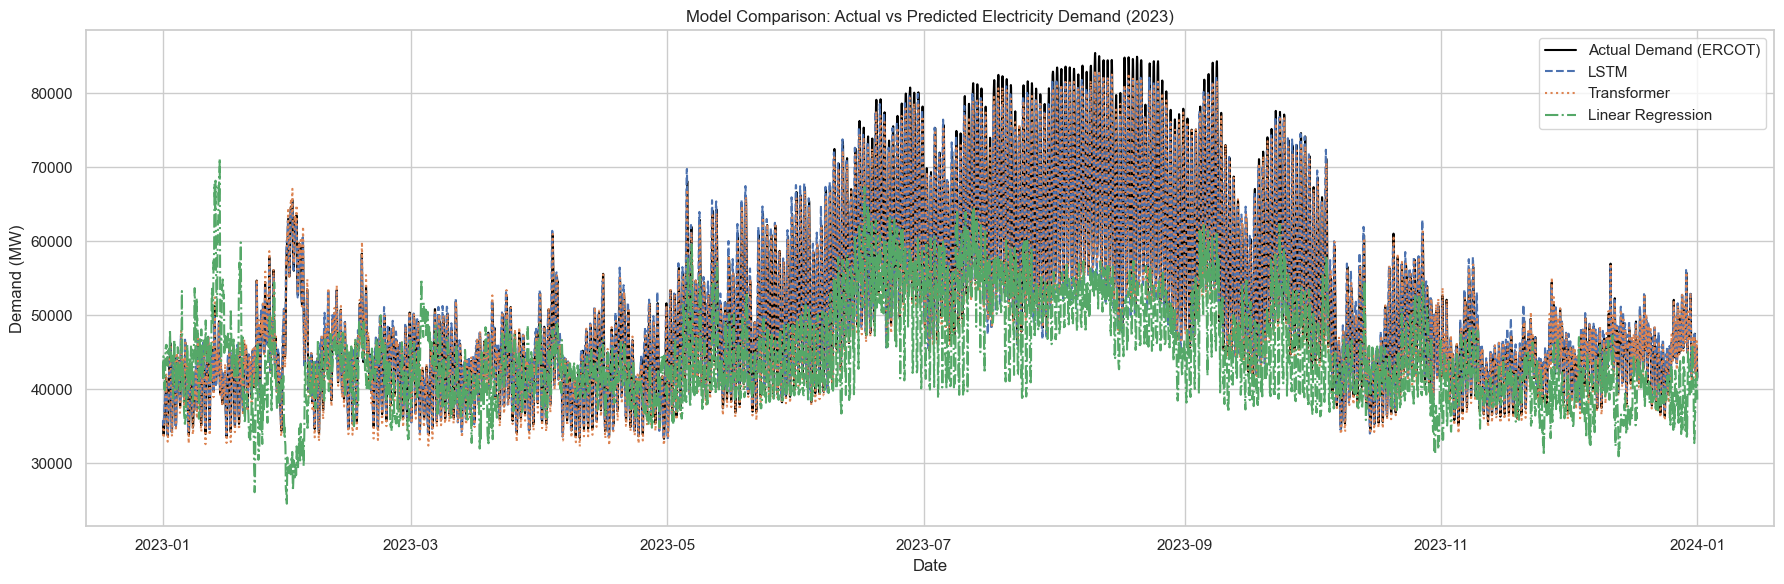

In [111]:
import matplotlib.pyplot as plt

# Function to create individual plots
def plot_model_vs_actual(df, model_col, model_name):
    plt.figure(figsize=(16, 6))
    plt.plot(df['timestamp'], df['ERCOT'], label='Actual Demand (ERCOT)', color='green')
    plt.plot(df['timestamp'], df[model_col], label=f'{model_name} Prediction', linestyle='--')
    plt.title(f'{model_name} vs Actual Electricity Demand (2023)')
    plt.xlabel('Date')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot each model separately
plot_model_vs_actual(merged_df, 'lstm_pred', 'LSTM')
plot_model_vs_actual(merged_df, 'transformer_pred', 'Transformer')
plot_model_vs_actual(merged_df, 'linear_regression_pred', 'Linear Regression')

# Combined comparison plot
plt.figure(figsize=(18, 6))
plt.plot(merged_df['timestamp'], merged_df['ERCOT'], label='Actual Demand (ERCOT)', color='black')
plt.plot(merged_df['timestamp'], merged_df['lstm_pred'], label='LSTM', linestyle='--')
plt.plot(merged_df['timestamp'], merged_df['transformer_pred'], label='Transformer', linestyle=':')
plt.plot(merged_df['timestamp'], merged_df['linear_regression_pred'], label='Linear Regression', linestyle='-.')
plt.title('Model Comparison: Actual vs Predicted Electricity Demand (2023)')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
